<a href="https://colab.research.google.com/github/fergogu27-ctrl/EDPII/blob/main/Diferencias%20progresivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CASO a) h = 0.1, k = 0.0005

h = 0.1, k = 0.0005, r = 0.050000, pasos de tiempo M = 1000, tiempo alcanzado t = 0.500000
r <= 0.5 -> esquema explícito condicionalmente estable (Von Neumann).

--- Resumen ---
Tiempo usado t = 0.500000
r = k/h^2 = 0.050000
Norma L2 (aprox): 1.466917e-04
Norma max:        2.074533e-04



,x,u_numeric,u_analytic,abs_error
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.002287,0.002222,0.000064
2,0.2,0.004349,0.004227,0.000122
3,0.3,0.005986,0.005818,0.000168
4,0.4,0.007037,0.006840,0.000197
5,0.5,0.007399,0.007192,0.000207
6,0.6,0.007037,0.006840,0.000197
7,0.7,0.005986,0.005818,0.000168
8,0.8,0.004349,0.004227,0.000122
9,0.9,0.002287,0.002222,0.000064


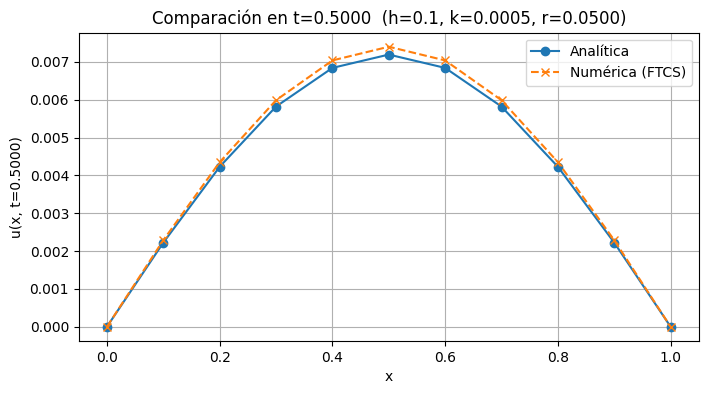

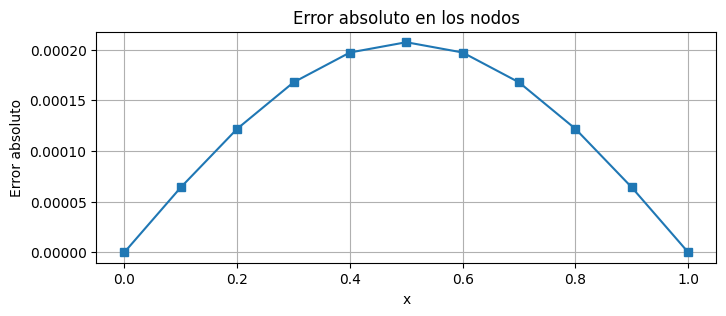



CASO b) h = 0.1, k = 0.01

h = 0.1, k = 0.01, r = 1.000000, pasos de tiempo M = 50, tiempo alcanzado t = 0.500000
AVISO: r > 0.5 -> esquema explícito inestable (se puede producir crecimiento numérico).

--- Resumen ---
Tiempo usado t = 0.500000
r = k/h^2 = 1.000000
Norma L2 (aprox): 9.444030e+04
Norma max:        1.364788e+05



,x,u_numeric,u_analytic,abs_error
0,0.0,0.000000,0.000000,0.000000
1,0.1,-30266.270026,0.002222,30266.272248
2,0.2,60588.054981,0.004227,60588.050754
3,0.3,-89862.842345,0.005818,89862.848163
4,0.4,115225.537917,0.006840,115225.531077
5,0.5,-132328.392814,0.007192,132328.400006
6,0.6,136478.815915,0.006840,136478.809075
7,0.7,-124251.368517,0.005818,124251.374336
8,0.8,94976.581153,0.004227,94976.576926
9,0.9,-51519.548023,0.002222,51519.550245


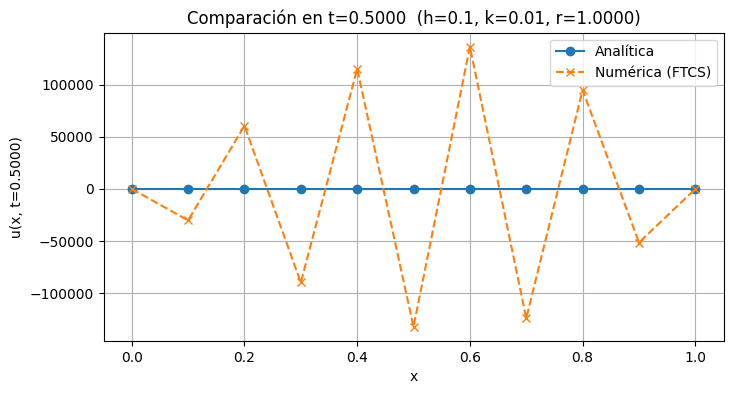

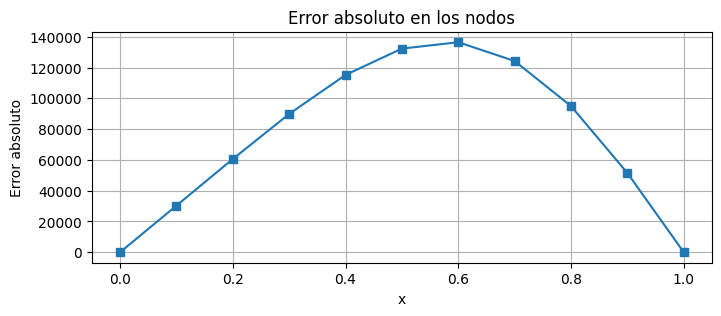

,case,r = k/h^2,t_reached,L2_norm,max_norm
0,"a: h=0.1, k=0.0005",0.05,0.5,0.000147,0.000207
1,"b: h=0.1, k=0.01",1.00,0.5,94440.300001,136478.809075



Observaciones:
- Caso (a): r = 0.0500 <= 0.5 -> esquema estable y buena aproximación.
- Caso (b): r = 1.0000 > 0.5  -> esquema explícito inestable; la solución numérica diverge/genera ruido.


In [1]:
# -*- coding: utf-8 -*-
"""
Resolución numérica de la ecuación del calor
    u_t - u_xx = 0,  0<x<1, t>0
con u(0,t)=u(1,t)=0 y u(x,0)=sin(pi x).

Se usa el esquema explícito FTCS (Forward Time Centered Space).
Se comparan dos casos:
 a) h=0.1, k=0.0005   (estable, r = k/h^2 = 0.05)
 b) h=0.1, k=0.01     (inestable, r = 1.0)
La comparación se hace en t_final = 0.5 con la solución analítica
    u(x,t) = exp(-pi^2 t) * sin(pi x)
"""

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML

plt.rcParams.update({'figure.max_open_warning': 0})

def solve_heat_explicit(h, k, t_final, verbose=True):
    """
    Resuelve la ecuación del calor mediante FTCS.
    Entradas:
      h       : paso espacial
      k       : paso temporal
      t_final : tiempo final donde se evalúa la solución
    Devuelve:
      x       : nodos espaciales (numpy array)
      u       : solución numérica en t_real (numpy array)
      r       : coeficiente k/h^2
      t_real  : tiempo real alcanzado (un múltiplo entero de k)
    """
    x = np.arange(0.0, 1.0 + 1e-12, h)      # nodos espaciales incluyendo 0 y 1
    Nx = len(x) - 1
    # condición inicial
    u = np.sin(np.pi * x)
    u[0] = 0.0
    u[-1] = 0.0

    r = k / (h**2)
    M = int(round(t_final / k))            # número entero de pasos de tiempo
    t_real = M * k

    if verbose:
        print(f"h = {h}, k = {k}, r = {r:.6f}, pasos de tiempo M = {M}, tiempo alcanzado t = {t_real:.6f}")
        if r > 0.5:
            print("AVISO: r > 0.5 -> esquema explícito inestable (se puede producir crecimiento numérico).")
        else:
            print("r <= 0.5 -> esquema explícito condicionalmente estable (Von Neumann).")

    u_new = u.copy()
    # bucle temporal
    for n in range(M):
        # imponer condiciones de frontera (aunque ya son 0)
        u_new[0] = 0.0
        u_new[-1] = 0.0
        # actualizar interior con FTCS
        for j in range(1, len(x)-1):
            u_new[j] = u[j] + r * (u[j+1] - 2.0*u[j] + u[j-1])
        # intercambio de referencias
        u, u_new = u_new, u

    return x, u, r, t_real

def analytic_solution(x, t):
    """Solución analítica u(x,t) = exp(-pi^2 t) * sin(pi x)"""
    return np.exp(- (np.pi**2) * t) * np.sin(np.pi * x)

def compare_and_show(h, k, t_final=0.5):
    """Resuelve, compara con la analítica, muestra tabla y gráficas."""
    x, u_num, r, t_real = solve_heat_explicit(h, k, t_final)
    u_ex = analytic_solution(x, t_real)
    abs_err = np.abs(u_num - u_ex)

    # normas de error
    L2_norm = np.sqrt(np.sum(abs_err**2) * h)   # aproximación de la norma L2 en [0,1]
    max_norm = np.max(abs_err)

    # preparar DataFrame para mostrar
    df = pd.DataFrame({
        'x': np.round(x, 8),
        'u_numeric': np.round(u_num, 8),
        'u_analytic': np.round(u_ex, 8),
        'abs_error': np.round(abs_err, 8)
    })

    print("\n--- Resumen ---")
    print(f"Tiempo usado t = {t_real:.6f}")
    print(f"r = k/h^2 = {r:.6f}")
    print(f"Norma L2 (aprox): {L2_norm:.6e}")
    print(f"Norma max:        {max_norm:.6e}\n")

    display(HTML("<h4>Tabla: comparación numérica vs analítica</h4>"))
    display(df)

    # Gráfica: solución analítica y numérica
    plt.figure(figsize=(8,4))
    plt.plot(x, u_ex, marker='o', label='Analítica')
    plt.plot(x, u_num, marker='x', linestyle='--', label='Numérica (FTCS)')
    plt.xlabel('x')
    plt.ylabel(f'u(x, t={t_real:.4f})')
    plt.title(f'Comparación en t={t_real:.4f}  (h={h}, k={k}, r={r:.4f})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica del error absoluto
    plt.figure(figsize=(8,3))
    plt.plot(x, abs_err, marker='s')
    plt.xlabel('x')
    plt.ylabel('Error absoluto')
    plt.title('Error absoluto en los nodos')
    plt.grid(True)
    plt.show()

    return df, L2_norm, max_norm, r, t_real

# ===== Ejecutar los dos casos pedidos y mostrar resumen =====
t_final = 0.5

print("CASO a) h = 0.1, k = 0.0005\n")
df_a, L2_a, max_a, r_a, t_a = compare_and_show(h=0.1, k=0.0005, t_final=t_final)

print("\n\nCASO b) h = 0.1, k = 0.01\n")
df_b, L2_b, max_b, r_b, t_b = compare_and_show(h=0.1, k=0.01, t_final=t_final)

# Resumen comparativo
summary = pd.DataFrame({
    'case': ['a: h=0.1, k=0.0005', 'b: h=0.1, k=0.01'],
    'r = k/h^2': [r_a, r_b],
    't_reached': [t_a, t_b],
    'L2_norm': [L2_a, L2_b],
    'max_norm': [max_a, max_b]
})
display(HTML("<h4>Resumen de errores (ambos casos)</h4>"))
display(summary.round(8))

print("\nObservaciones:")
print("- Caso (a): r = {:.4f} <= 0.5 -> esquema estable y buena aproximación.".format(r_a))
print("- Caso (b): r = {:.4f} > 0.5  -> esquema explícito inestable; la solución numérica diverge/genera ruido.".format(r_b))
